<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Tools" data-toc-modified-id="Tools-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tools</a></span></li><li><span><a href="#Select-your-motif" data-toc-modified-id="Select-your-motif-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select your motif</a></span></li><li><span><a href="#Check-the-motif's-point-symmetry" data-toc-modified-id="Check-the-motif's-point-symmetry-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check the motif's point symmetry</a></span></li><li><span><a href="#Select-the-global-pattern-symmetry" data-toc-modified-id="Select-the-global-pattern-symmetry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Select the global pattern symmetry</a></span></li><li><span><a href="#Proceed-to-Step-3" data-toc-modified-id="Proceed-to-Step-3-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Proceed to Step 3</a></span></li></ul></div>

In [1]:
import json, os
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

Overview
--------
This is **STEP 2** in the design procedure. If you plan to use default motifs you may proceed; otherwise go to motif_library/Create_Motifs.ipynb to design your motif first.

# Tools

In [2]:
library = '../motif_library/'
motif_coords = None
motif_types = None
motif_point_symmetry = None
induced = 'c1'

motif_selector = widgets.Dropdown(
    options=[f for f in os.listdir(library) if f.endswith('.json')],
    description='Motif',
    disabled=False,
    value=None
)

def on_motif_change(v):
    global motif_coords
    global motif_types
    global motif_point_symmetry
    info = json.load(open(library+v['new'], 'r'))
    motif_coords = info['coords'] 
    motif_types = info['types'] 
    motif_point_symmetry = info['symmetry'] 

motif_selector.observe(on_motif_change, names='value')

induced_selector = widgets.ToggleButtons(
    options=['Ignore (c1)', 'Use motif'],
    description=r'$S(\mathcal{P}|M):$',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Do not extend any of motif\'s symmetry to the tiling', 'Use some of motif\'s symmetry in tiling'],
#     icons=['check'] * 3
)

def on_induced_change(v):
    global induced
    if v['new'] == "Use motif":
        induced = motif_point_symmetry
    else:
        induced = 'c1'

induced_selector.observe(on_induced_change, names='value')

def plot(coords):
    coords = np.array(coords)
    plt.plot(coords[:,0], coords[:,1], 'o')
    plt.gca().axis('equal')
    
def convert_pym_sch(sch):
    """
    Convert 3D Schoenflies notation from pymatgen to 2D.
    
    All "molecules" are expected to be planar so the "z"-plane
    is effectively a "horizontal" mirror. 
    
    This also is designed to specifically handle to the 
    way that pymatgen responds; if pymatgen conventions change
    this might need to be updated.
    
    See visualizations and references here:
    * https://demonstrations.wolfram.com/MolecularPointGroups/
    * https://en.wikipedia.org/wiki/Schoenflies_notation
    * https://en.wikipedia.org/wiki/Point_groups_in_three_dimensions
    """

    if sch == "C1" or sch == "C1h" or sch == "C1v" or sch == "Cs": # From wiki
        return "c1"
    elif sch == "C2v" or sch == "D1h": # From wiki
        return "d1"
    elif sch.endswith("h") :
        return sch[:2].lower() # Dxh = dx, Cxh = cx
    else:
        raise Exception("unrecognized Schoenflies point group {}".format(sch))

# Select your motif

In [3]:
display(motif_selector)

Dropdown(description='Motif', options=('d3_triangle.json', 'c6_swirl_L.json', 'dinf_circle.json', 'c4_swirl.js…

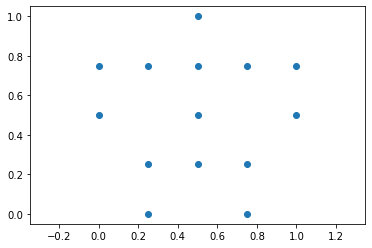

In [43]:
plot(motif_coords)

# Check the motif's point symmetry

You must have [pymatgen](https://pymatgen.org/index.html) installed for this to work, otherwise you can consider doing this manually and can skip ahead.

**Note**: this is intended to be a helpful check, but ultimately symmetry determination has a numerical precision associated with it.  If points are too close together, or tolerances poor, a bad assignment can be made.  The user should always check these results make sense. A circle, for example, if represented by a set of points always has finite symmetry, not $d_{\infty}$. This section is just to provide an attempted check of the motif the user manually created (and assigned a 2D point symmetry).  

In [23]:
import pymatgen.symmetry.analyzer as psa
from pymatgen.core.structure import Molecule
from scipy.spatial import distance_matrix

In [24]:
# For numerical reasons, pymatgen works best when things are at least 1A apart, so center and scale
# so nearest particles are 1 "unit" apart
min_d = np.min(distance_matrix(motif_coords, motif_coords)[np.triu_indices(len(motif_coords), 1)])
safer_coords = (motif_coords - np.mean(motif_coords, axis=0))/min_d

mol = Molecule(
    species=["H"]*len(safer_coords),
    coords=np.hstack((np.array(safer_coords), np.zeros((len(safer_coords),1)))),
    validate_proximity=True
)

a = psa.PointGroupAnalyzer(mol, tolerance=0.3, eigen_tolerance=0.01)
pmg_symm = convert_pym_sch(a.sch_symbol)

In [25]:
# Check that pymatgen agrees with the library file
assert(motif_point_symmetry == pmg_symm), 'pymatgen and library file do not agree on symmetry'

# Select the global pattern symmetry

Remember, if a motif has a certain symmetry (e.g., $S(M) = c6$), it can induce any of its subgroups (e.g., $S(\mathcal{P}|M) = c3$)

1. [**safe**] If $S(\mathcal{P}|M)$ = $S(M)$ then you can use these IH tiles without fear. The escherization *algorithm will place the motif so that it induces all of its symmetries* on the pattern, and since the motif has no more, there are no other problems. 

2. [**forbidden**] If a proper subset (proper subgroup) of the motif's symmetries are induced on the pattern, $S(\mathcal{P}|M) \subset S(M)$, you have to check if any proper supergroup of $S(\mathcal{P}|M)$ that is a (inclusive, i.e., not proper) subgroup of $S(M)$ is strictly forbidden. 

    > Check for all $X$ such that $S(\mathcal{P}|M) \subset X$ and $X \subseteq S(M)$. If any such $X$ is a (minimal) forbidden supergroup, then this tile is forbidden.

    In other words, induction of $S(\mathcal{P}|M)$ **always** causes the induction of even more symmetries of the motif on the global pattern which changes the point pattern type (not always the symmetry, though, but usually - cf. G&S, PP31->32 and PP40->41).  As best practice, I will just take this as a requirement. A pattern type might also be forbidden if it requires the induction of a set of symmetries the motif does not have as a (inclusive, i.e., not proper) subgroup of $S(M)$; for example, you cannot induce d3 if the motif has d4 symmetry.

3. [**dangerous**] There is also a third case where $S(\mathcal{P}|M) \subset S(M)$ and neither $S(M)$, nor any of its subgroups, are strictly forbidden, but if the tile has the right shape, for example, it is possible to change the pattern. These are the remainder of the rows. Consider the following example:

    * If $S(M) =$ d2, can make PP20 with IH 17, 74 without any problem. [**safe**]
    * If $S(M) =$ d4, it is possible to make PP20 with these IH tiles, and d4 is not *strictly* forbidden. [**dangerous**]
    * However, if those tiles have a certain shape then the cmm group these belong to can induce d4 which promotes the pattern to p4m, so d4 is *sometimes* incorrect.  Of course, c1 is always a subgroup.
    
The **safe** and **forbidden** cases are the "black and white" ends of the spectrum; the "dangerous" ones are a gray area.  They offer the possibility of creating additional symmetries that might not be strictly safe, but require that you be careful with your design. If we make a dangerous choice, we can gain insight into the problems that might arise by using the `watch_out_for` function.

Some interesting limits:
* $S(M) = d_{\infty}$ (Isotropic circle - 0 are safe, all with any strictly forbidden are forbidden, all with no strictly forbidden are dangerous)
* $S(M) = c1$ (Asymmetric motif - 46 FD tiles are all safe, 0 dangerous, other 47 forbidden)

Notes on Notation:
* [Symbols](https://www.mathsisfun.com/sets/symbols.html)
* [(Proper) Subgroups](https://mathworld.wolfram.com/ProperSubgroup.html)

In [26]:
## To see this example, uncomment the line below
# motif_point_symmetry = 'd4'

In [44]:
import table
safe, dangerous, forbidden = table.prioritize(motif_point_symmetry)     

In [45]:
safe.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP4,pm,d1,"['p1', 'pg', 'cm', '*']",d2,[64]
PP6,cm,d1,"['p1', 'pg']",d2,"[12, 14, 68]"
PP13,pmg,d1,"['pg', 'p2', 'pgg']",,"[13, 15, 66, 69]"
PP15,pmm,d1,"['pm', 'p2', 'pmg(2)', 'cmm', '*']",,[65]
PP19,cmm,d1,"['cm', 'p2', 'pgg', 'pmg']",,"[26, 67, 91]"
PP25,p31m,d1,['p3'],,"[16, 36]"
PP28,p3m1,d1,['p3'],,[35]
PP35,p4g,d1,"['pgg', 'p4']",,"[29, 71]"
PP38,p4m,d1,"['cmm', 'p4', 'p4g', '*']",,[82]
PP39,p4m,d1,"['pmm', 'p4', 'p4g']",,[70]


In [46]:
dangerous.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP1,p1,c1,['Primitive'],c2,"[1, 41]"
PP2,pg,c1,['Primitive'],dinf,"[2, 3, 43, 44]"
PP3,pm,c1,['Primitive'],dinf,[42]
PP5,cm,c1,['Primitive'],dinf,"[22, 45, 83]"
PP7,p2,c1,['Primitive'],,"[4, 23, 46, 47, 84]"
PP9,pgg,c1,['Primitive'],,"[5, 6, 25, 27, 51, 52, 53, 86]"
PP11,pmg,c1,['Primitive'],,"[24, 49, 50, 85]"
PP14,pmm,c1,['Primitive'],,[48]
PP17,cmm,c1,['Primitive'],,"[54, 78]"
PP21,p3,c1,['Primitive'],,"[7, 33]"


In [42]:
table.watch_out_for(72, dangerous, motif_point_symmetry).style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP41,p4m,d4,"['p1', 'pg(2)', 'pm(2)', 'cm(2)', 'p2(3)', 'pgg(3)', 'pmg(3)', 'pmm(3)', 'cmm(4)', 'p4(3)', 'p4g(3)', '*(2)']",,[76]


In [21]:
forbidden.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP8,p2,c2,"['p1', '*']",,"[8, 57]"
PP10,pgg,c2,['pg'],dinf,"[9, 59]"
PP12,pmg,c2,"['pg', 'pm', 'pgg', '*']",dinf,[58]
PP16,pmm,d2,"['p1', 'pg', 'pm(2)', 'cm', 'p2(3)', 'pgg', 'pmg(2)', 'cmm(3)', '*(2)']",,[72]
PP18,cmm,c2,"['cm', 'pgg', 'pmm']",dinf,[60]
PP20,cmm,d2,"['p1', 'pg', 'cm', 'p2(2)', 'pgg(2)', 'pmg']",,"[17, 74]"
PP22,p3,c3,"['p1', '*']",c6,[10]
PP24,p31m,c3,"['cm', 'p3m1']",dinf,[89]
PP26,p31m,d3,"['p1', 'pg', 'cm', 'p3(2)']",d6,[18]
PP29,p3m1,d3,"['p1', 'pg', 'cm', 'p3(2)', 'p31m']",d6,[19]


# Proceed to Step 3

3a. (optional) Visit [https://isohedral.ca/software/tactile/](https://isohedral.ca/software/tactile/) for an interactive experience with the tile you have selected.

3b. Use examples/pso_safe and/or examples/pso_dangerous for an illustration of how to use PSO to optimize a tile to "fit" around a motif and create a colloid out of the two.

3c. Run the optimization.

3d. Check your results. If you are using a "safe" choice, you are guaranteed to have the final desired symmetry; however, a "dangerous" choice may lead to something unexpected. In the latter case, use the watch_out_for() function to help point out what symmetry you might end up with instead.

* As best practice, you should **always** create a non-primitive unit cell (e.g., 3x3) and visually check what symmetry your final design will have.

* See `Colloid::unitCell()` C++ function and example/unit_cell.